In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, normaltest, probplot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error



# Exploracion de datos de datos

In [27]:
path = "data/sym_h_reduced.csv"

In [28]:
df = pd.read_csv(path)
df.head()
print(df)

       Unnamed: 0            timestamp        DATE          TIME  DOY  ASY-D  \
0         3201120  2013-02-01 00:00:00  2013-02-01  00:00:00.000   32   15.0   
1         3201121  2013-02-01 00:01:00  2013-02-01  00:01:00.000   32   14.0   
2         3201122  2013-02-01 00:02:00  2013-02-01  00:02:00.000   32   13.0   
3         3201123  2013-02-01 00:03:00  2013-02-01  00:03:00.000   32   13.0   
4         3201124  2013-02-01 00:04:00  2013-02-01  00:04:00.000   32   13.0   
...           ...                  ...         ...           ...  ...    ...   
40315     3241435  2013-02-28 23:55:00  2013-02-28  23:55:00.000   59   24.0   
40316     3241436  2013-02-28 23:56:00  2013-02-28  23:56:00.000   59   24.0   
40317     3241437  2013-02-28 23:57:00  2013-02-28  23:57:00.000   59   23.0   
40318     3241438  2013-02-28 23:58:00  2013-02-28  23:58:00.000   59   21.0   
40319     3241439  2013-02-28 23:59:00  2013-02-28  23:59:00.000   59   21.0   

       ASY-H  SYM-D  SYM-H  
0       34

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40320 entries, 0 to 40319
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  40320 non-null  int64  
 1   timestamp   40320 non-null  object 
 2   DATE        40320 non-null  object 
 3   TIME        40320 non-null  object 
 4   DOY         40320 non-null  int64  
 5   ASY-D       40320 non-null  float64
 6   ASY-H       40320 non-null  float64
 7   SYM-D       40320 non-null  float64
 8   SYM-H       40320 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 2.8+ MB


#### Ordenar los datos en forma cronologica

In [30]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.sort_values('timestamp')

df.set_index('timestamp', inplace= True)

#### Obtener metricas basicas

In [31]:
df.describe()

,Unnamed: 0,DOY,ASY-D,ASY-H,SYM-D,SYM-H
count,4.032000e+04,40320.000000,40320.000000,40320.000000,40320.000000,40320.000000
mean,3.221280e+06,45.500000,14.099554,16.708358,-1.149479,-8.146478
std,1.163953e+04,8.077847,7.907772,9.462086,2.447383,9.760388
min,3.201120e+06,32.000000,1.000000,1.000000,-13.000000,-45.000000
25%,3.211200e+06,38.750000,9.000000,10.000000,-2.000000,-14.000000
50%,3.221280e+06,45.500000,12.000000,15.000000,-1.000000,-8.000000
75%,3.231359e+06,52.250000,17.000000,21.000000,0.000000,-1.000000
max,3.241439e+06,59.000000,60.000000,82.000000,7.000000,16.000000


#### Control de datos faltantes

In [32]:
faltantes = df.isna().sum()
print(f"Datos faltantes:\n{faltantes}")

# pd.to_numeric(...) intenta convertir todos los valores de la 
# col indicada a un tipo numerico (float), si no puede lo reemplaza
# por Nan. La op errors = 'coerce'   INDICA FORZAR CONVERSION 
# isna() devuelve un arreglo bool indicando las posiciones con NaN.
mask_non_numeric = pd.to_numeric(df['SYM-H'], errors='coerce').isna()
print(f"\nDatos corruptos: {mask_non_numeric.sum()}")


Datos faltantes:
Unnamed: 0    0
DATE          0
TIME          0
DOY           0
ASY-D         0
ASY-H         0
SYM-D         0
SYM-H         0
dtype: int64

Datos corruptos: 0


#### Deteccion de outliers (Por RI)

 Valores alejados:
timestamp
2013-02-07 09:43:00   -34.0
2013-02-07 09:44:00   -34.0
2013-02-07 09:45:00   -34.0
2013-02-07 09:46:00   -34.0
2013-02-14 05:10:00   -34.0
                       ... 
2013-02-23 02:45:00   -34.0
2013-02-23 02:46:00   -34.0
2013-02-23 02:47:00   -34.0
2013-02-23 02:48:00   -34.0
2013-02-23 02:49:00   -34.0
Name: SYM-H, Length: 594, dtype: float64


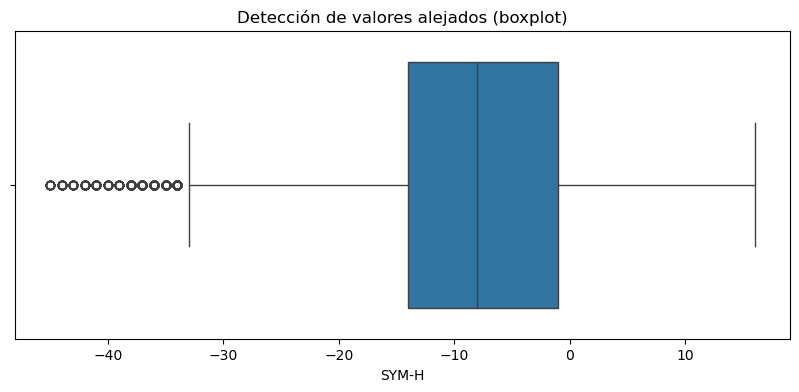

In [33]:
Q1 = df['SYM-H'].quantile(0.25)
Q3 = df['SYM-H'].quantile(0.75)
RI =  Q3 - Q1
lim_inf = Q1 - 1.5*RI
lim_sup = Q3 + 1.5*RI

outliers = df[(df['SYM-H'] < lim_inf) | (df['SYM-H'] > lim_sup)]
print(f" Valores alejados:\n{outliers['SYM-H']}")

plt.figure(figsize=(10,4))
sns.boxplot(x=df['SYM-H'])
plt.title('Detección de valores alejados (boxplot)')
plt.show()


Asimetría (skew): -0.416
Curtosis: 0.394
p-value del test de normalidad: 0.00000
➡️ Los datos NO siguen una distribución normal (se rechaza H₀).


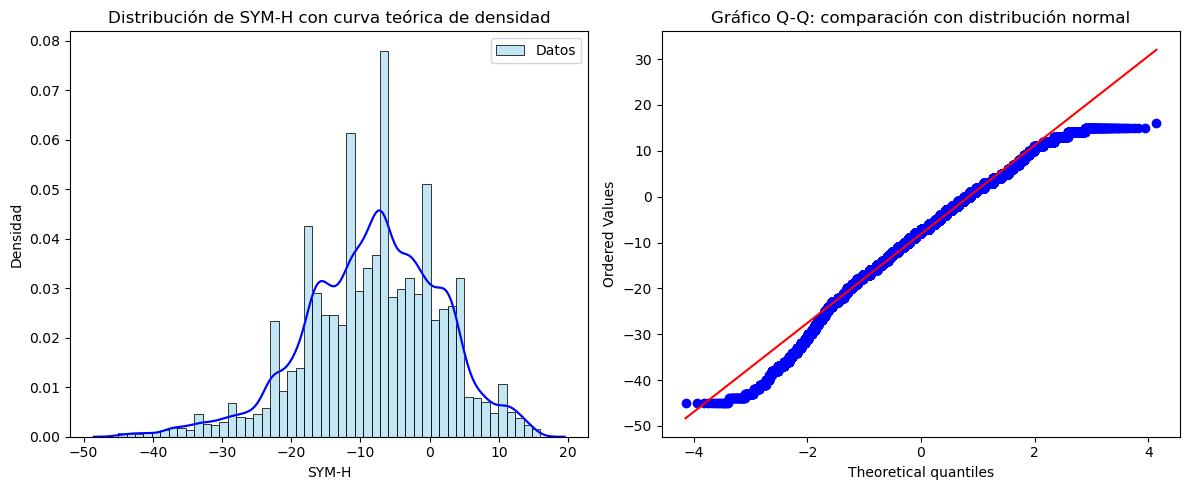

In [34]:
col = 'SYM-H'

# --- Cálculo de medidas estadísticas ---
asimetria = skew(df[col], nan_policy='omit')
curtosis_val = kurtosis(df[col], nan_policy='omit')
stat, p = normaltest(df[col].dropna())

print(f"Asimetría (skew): {asimetria:.3f}")
print(f"Curtosis: {curtosis_val:.3f}")
print(f"p-value del test de normalidad: {p:.5f}")

if p < 0.05:
    print("➡️ Los datos NO siguen una distribución normal (se rechaza H₀).")
else:
    print("✅ Los datos podrían seguir una distribución normal (no se rechaza H₀).")

plt.figure(figsize=(12,5))

# --- Subgráfico 1: Histograma con curva teórica ---
plt.subplot(1, 2, 1)
sns.histplot(df[col], bins=50, kde=True, stat="density", color="skyblue", label="Datos")
sns.kdeplot(df[col], color="blue")
plt.title('Distribución de SYM-H con curva teórica de densidad')
plt.xlabel('SYM-H')
plt.ylabel('Densidad')
plt.legend()

# --- Subgráfico 2: Q-Q plot ---
plt.subplot(1, 2, 2)
probplot(df[col].dropna(), dist="norm", plot=plt)
plt.title('Gráfico Q-Q: comparación con distribución normal')

plt.tight_layout()
plt.show()


El análisis de normalidad muestra que la variable SYM-H no sigue una distribución normal.
Presenta un sesgo negativo : asimetría hacia valores bajos

#### Grafica de la serie temporal completa

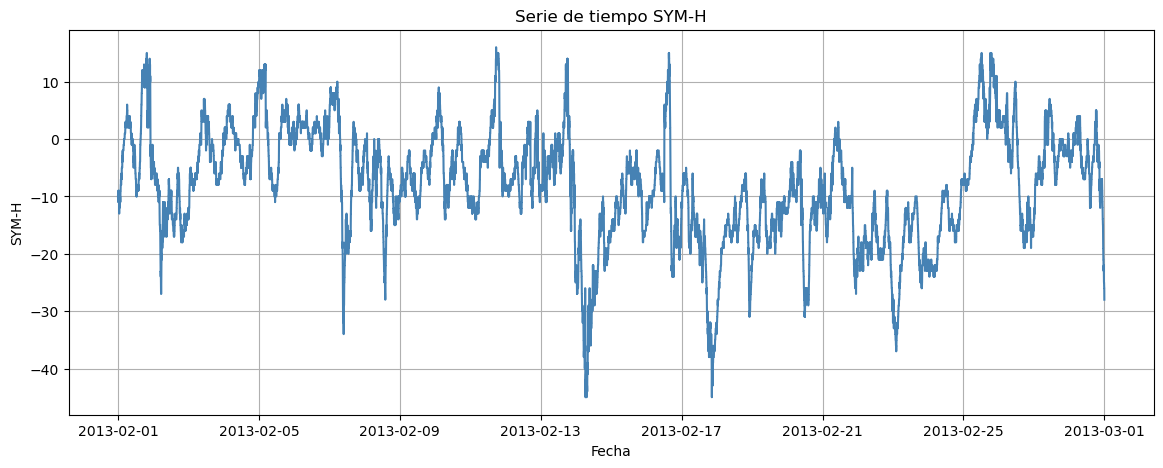

In [35]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df[col], color = 'steelblue')
plt.title('Serie de tiempo SYM-H')
plt.xlabel('Fecha')
plt.ylabel('SYM-H')
plt.grid(True)
plt.show()

# Desarrollo de herramientas

In [36]:
def select_interv(df, start, end):
    return df.loc[start : end]

#### Split dataset

Para problemas de series temporaleS **NO** debemos mezclar los datos. El pasado se utiliza para predecir el futuro y no al revez. Por ello hacemos un split directo del 80% para train y 20% para test

In [37]:
def split_dataset(df, percentaje_train):
    '''
        df : set de datos temporal a dividir
        percentaje_train : porcentaje del dataset a utilizar en el entrenamiento
    '''
    train_size = int(len(df)*(percentaje_train/100.0))
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    return train, test


#### Sliding window

Es una tecnica para transformar una sola serie temporal larga en varias ejemplos de entrenamiento.

In [38]:
def sliding_window(series, n_input, n_output):
    '''
        series : set de datos
        n_imput : cuantos pasos atras utilizamos para predecir
        n_output : cuando pasas adelante queremos predecir

        Retorna el arreglo con datos de entrenamiento 'x'
        y el arreglo con sus respectivos datos de prueba 'y'
    '''
    x = []
    y = []
    n = len(series) - n_input - n_output
    for i in range(n):
        # [a : b] 
        # a : incluye
        # b : se excluye
        x.append(series[i : i + n_input])
        y.append(series[i + n_input : i + n_input + n_output])

    return np.array(x), np.array(y)

#### Ejemplo:
serie = np.array([10, 11, 12, 13, 14, 15, 16])

x, y = sliding_window(serie, n_input=3, n_output=1)

print("X:", x)

print("y:", y)

X: { [10 11 12] [11 12 13] [12 13 14] [13 14 15]}

y: { [13]       [14]       [15]       [16] }

In [39]:
def walking_forward_multistep_fast(model, test_scaled, n_input, n_output, scaler = None):

    n = len(test_scaled) - n_input - n_output + 1

    #Genera un arreglo de ventanas.
    X_all = np.array([test_scaled[i : i + n_input] for i in range(n)])

    #Asegura que X_all tenga la forma que LSTM necesita:
    # samples : n -> cant de ventanas
    # timesteps = n_imput -> longitud de cada secuencia (ventana)
    # features = 1 -> solo una var: SYM-H
    X_all = X_all.reshape((n, n_input, 1))

    #Al tener X_all todas las secuencias de entrada
    # y se hace una sola llamada, TensorFlow las procesa a todas
    # en paralelo y devuelve el array de predicciones completo.
    '''
        El modelo recibe todas las ventanas juntas, y devuelve una matriz con las predicciones.
        Cada fila de la matriz corresponde a una ventana de entrada y contiene n_output valores,
        que son las predicciones
        La matriz queda del orden n x n_output.
    '''
    yhat_all = model.predict(X_all, verbose = 0)
    
    # test_scaled es un arreglo 2D de la forma test_size x 1
    # para cada ventana, se toman los n_output valores reales correspondientes.
    reals_all = np.array([
        test_scaled[i + n_input : i + n_input + n_output, 0]
        for i in range(n)
    ])


    # Si se pasa por parametro es scaler, vuelvo los datos a su escala original.
    if scaler is not None:
        preds = scaler.inverse_transform(yhat_all)
        reals = scaler.inverse_transform(reals_all)
    else:
        preds = yhat_all
        reals = reals_all
    
    # Flatten() lo que hace es convertir el arreglo 2D a un vector 1D
    # Pone todas las filas a una a la par de la otra, y asi queda el vector 1D.
    # Se realiza esto para poder calcular metricas como el MSE.
    reals_flat = reals.flatten()
    preds_flat = preds.flatten()

    #Calcular metricas:
    mse = mean_squared_error(reals_flat, preds_flat)
    rmse = np.sqrt(mse)
        
    return reals, preds, {"MSE" : mse, "RMSE" : rmse}
    

In [40]:
def build_model(n_input, n_output, neurons):
    '''
        Crea un modelo LSTM con una cantidad variable de neuronas.
    '''
    model = Sequential([
        Input(shape = (n_input,1)),
        LSTM(neurons, activation='tanh', dropout = 0.1, recurrent_dropout=0.1),
        Dense(n_output)
    ])
    model.compile(optimizer='adam', loss = 'mse')

    return model

In [41]:
def grid_search(train_scaled, test_scaled, n_input_list, n_output, neuron_list, scaler, epoch = 5):
    '''
    Explora distintas combinaciones de n_imput y neuronas
    Retorna la combinacion con menor error RMSE global
    '''
    results = []

    #Precomputo la ventana mas grande 1 sola vez, mas eficiente.
    max_n_input = max(n_input_list)
    full_X, full_y = sliding_window(train_scaled, max_n_input, n_output)

    #Formatear full_X para LSTM:
    full_X = full_X.reshape((full_X.shape[0], max_n_input, 1))

    es = EarlyStopping( patience = 3, restore_best_weights = True)


    for n_input in n_input_list:
        for neurons in neuron_list:
            # Genero los datos de entrenamiento (ventanas)
            X_train = full_X[:, -n_input:, :]
            y_train = full_y
            
            #crear y entrenar el modelo
            model = build_model(n_input, n_output, neurons)
          
            history = model.fit(X_train, y_train, epochs = epoch, validation_split = 0.2 ,verbose = 0, callbacks=[es])

            reals, preds, metrics = walking_forward_multistep_fast(
                model, test_scaled, n_input, n_output, scaler=scaler
            )

            rmse = metrics["RMSE"]
            mse = metrics["MSE"]

            results.append({
                "n_input": n_input,
                "neurons": neurons,
                "MSE": mse,
                "RMSE": rmse,
                "model": model,  # guardamos el modelo entrenado
                "history" : history,
                "preds" : preds,
                "reals" : reals
            })

            print(f"n_input = {n_input}, neurons = {neurons} -> RMSE = {rmse:.4f}")
    
    results = sorted(results, key = lambda x: x["RMSE"])
    best = results[0]

    print("\nMejor combinacion encontrada:")
    print(f"n_input{best['n_input']}, neurons = {best['neurons']}, RMSE = {best['RMSE']:.4f}")

    return best, results

# Ingenieria de datos

#### Dividimos el dataset en train_set y test_set

In [42]:
data = df['SYM-H']
train, test = split_dataset(data, 80)

#### Escalado de datos

In [43]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled = scaler.transform(test.values.reshape(-1,1))

# Setup para Grid Search

El **SYM-H** mide variaciones del campo geomagnetico cada minuto.

Cuando ocurre un evento geomagnetico, por ej, tomarmenta solar, el indice cambia durante un bloque continuo de minutos, no bruscamente cada minuto.

Por lo que SYM-H tiene correlacion temporal: lo que paso ahora, depende de lo que paso hace X minutos antes.

Del estudio sale que:
- Un descenso de SYM-H suele durar 5 - 60 minutos.
- Una fase de recuperacion puede durar otros 5 - 60 min

Entonces se prueban ventanas de 5 a 120 min ya que SYM-H suele mostrar cambios que duran decenas de minutos.

In [44]:
n_input_list = [10, 30, 60, 120]

#### Neurons - Numeros de celdas para LSTM

Se probaran arquitecturas de 8 a 64 celdas, para explorar modelos simple  hasta medianos.

In [45]:

neuron_list = [8, 16, 32]
n_output = 10

# Prueba de modelos

In [ ]:
best, result = grid_search(train_scaled , test_scaled, n_input_list, n_output, neuron_list, scaler, epoch=5)

results_df = pd.DataFrame(result)

n_input = 10, neurons = 8 -> RMSE = 3.3880
n_input = 10, neurons = 16 -> RMSE = 4.6913
n_input = 10, neurons = 32 -> RMSE = 2.6605
n_input = 30, neurons = 8 -> RMSE = 4.8772
n_input = 30, neurons = 16 -> RMSE = 3.0043
n_input = 30, neurons = 32 -> RMSE = 3.7874
n_input = 60, neurons = 8 -> RMSE = 4.5157
n_input = 60, neurons = 16 -> RMSE = 4.0162
n_input = 60, neurons = 32 -> RMSE = 3.1411
n_input = 120, neurons = 8 -> RMSE = 5.4203
n_input = 120, neurons = 16 -> RMSE = 2.8074
n_input = 120, neurons = 32 -> RMSE = 3.2180

Mejor combinacion encontrada:
n_input10, neurons = 32, RMSE = 2.6605


# Evaluacion del modelo

#### Grafica de Loss vs Validation_Loss

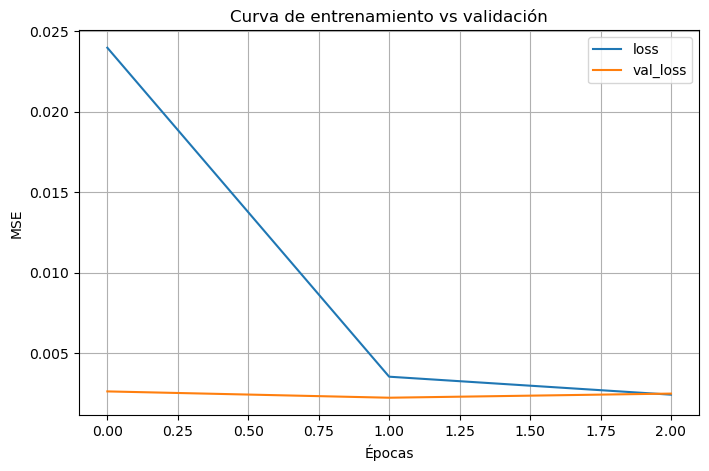

In [60]:
history = best["history"]

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Curva de entrenamiento vs validación")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

#### Grafica de Valores reales Vs Prediccion

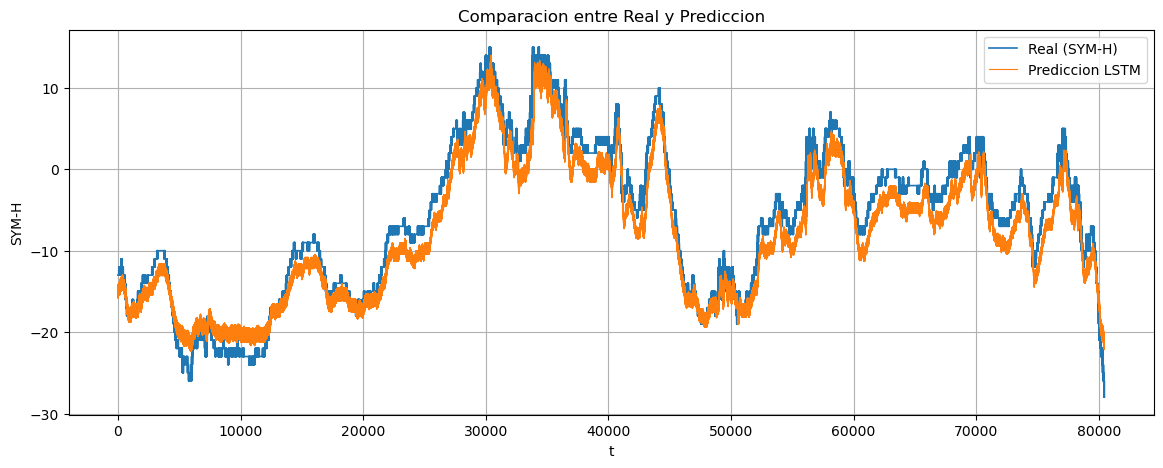

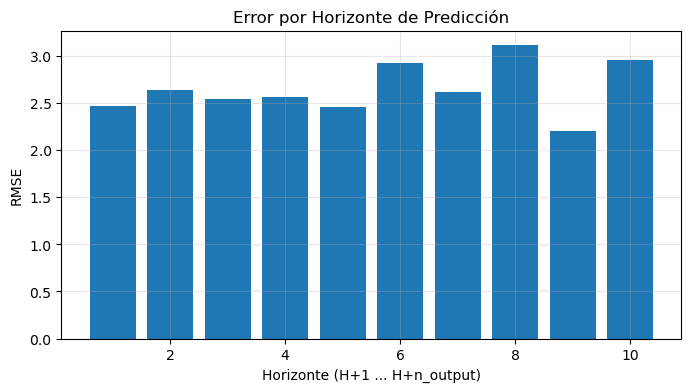

RMSE por horizonte: [2.46318663827804, 2.6385022301082097, 2.5383758922123065, 2.568301147916229, 2.4590753019227924, 2.925454837904163, 2.614805355193473, 3.1129236552540935, 2.2060264897517525, 2.951846614967423]


In [61]:

preds = best["preds"]
reals = best["reals"]
reals_flat = reals.flatten()
preds_flat = preds.flatten()

plt.figure(figsize=(14,5))
plt.plot(reals_flat, label="Real (SYM-H)", linewidth = 1.2)
plt.plot(preds_flat, label="Prediccion LSTM", linewidth = 0.8)
plt.title('Comparacion entre Real y Prediccion')
plt.xlabel("t")
plt.ylabel("SYM-H")
plt.legend()
plt.grid()
plt.show()

rmse_h = [
    np.sqrt(mean_squared_error(reals[:, h], preds[:, h]))
    for h in range(reals.shape[1])
]

plt.figure(figsize=(8,4))
plt.bar(range(1, len(rmse_h)+1), rmse_h)
plt.title('Error por Horizonte de Predicción')
plt.xlabel('Horizonte (H+1 ... H+n_output)')
plt.ylabel('RMSE')
plt.grid(alpha=0.3)
plt.show()

print("RMSE por horizonte:", rmse_h)



#### Error por Horizonte de Prediccion

Muestra como se degrada la precision del modelo LSTM a medida que intenta predecir valores mas lejanos en el futuro.

La prediccion inmediata (H+1) tiene el error (RMSE) mas bajo, mientras que los horizontes mas alejasdos, H+8 , H+10 presentan mayores errores. 

Es un comportamiento esperado ya que la incertidumbre aumenta conforme se intenta predecir varios pasos hacia adelante.